In [1]:
from app.shared.config import settings

/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of SECRET_KEY is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)
/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of FIRST_SUPERUSER_PASSWORD is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)


["{'question': 'Can I change my seat assignment after I have checked in?', 'answer': 'As long as your boarding pass has not yet been printed, you can still change your seat number after check-in. Click for details.'}",
 "{'question': 'Can I check in online for connecting flights with other airlines?', 'answer': 'If your journey starts with Turkish Airlines and continues on a partner airline, and check-in is available for the partner airline in concern you can check in online for the entire trip.'}",
 "{'question': 'Can I check in online for group tickets?', 'answer': 'For group tickets purchased from a travel agency, please write the surnames of the passengers in the group together with their ticket numbers, one by one. You can check in up to 9 passengers in one transaction.'}",
 "{'question': 'Can I choose emergency exit seats during online check-in or self-service kiosk check-in?', 'answer': 'Emergency exit seats can be selected and purchased before or during check-in. Check-in for p

In [1]:
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings

from langchain_openai import ChatOpenAI
import nest_asyncio
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from app.shared.config import settings
model = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# if settings.VECTOREDB_DIR and settings.STATUS == "MOBILE":
if True:  
    vectorstore = Chroma(
        collection_name="qa_collection",
        embedding_function=embeddings,
        persist_directory=settings.VECTOREDB_DIR,
    )

else:
    vectorstore = Chroma.from_texts(
        [str(qa) for qa in qas],
        embedding=embeddings,
        persist_directory=settings.VECTOREDB_DIR,
        metadatas=qas,
        collection_name="qa_collection",
    )


retriever = vectorstore.as_retriever()



from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers.document_compressors import LLMListwiseRerank
from langchain_text_splitters import CharacterTextSplitter
from langchain.retrievers import ContextualCompressionRetriever

def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

# splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=0, separator=". ")
redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
# relevant_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.46)
_filter = LLMListwiseRerank.from_llm(model)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[redundant_filter, _filter]
)
compression_retriever = ContextualCompressionRetriever(
    base_retriever=retriever,
    base_compressor=pipeline_compressor,
)

retrieval_chain = (
    {
        "context": compression_retriever.with_config(run_name="Docs"),
        "question": RunnablePassthrough(),
    }
    | prompt
    | model
    | StrOutputParser()
)

/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of SECRET_KEY is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)
/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of FIRST_SUPERUSER_PASSWORD is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)


In [2]:
retrieval_chain.invoke("How do I check-in at counter?" )

'After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your boarding pass.'

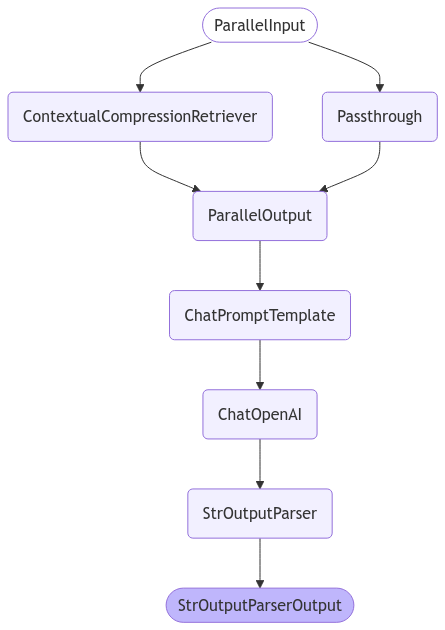

In [43]:
from IPython.display import Image, display
image = retrieval_chain.get_graph().draw_mermaid_png()
display(Image(data=image))


In [23]:
settings.VECTOREDB_DIR

'/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/data/vectoredb'

In [3]:
vectorstore.similarity_search("harrison likes?" , k=2 )


TypeError: Collection.query() got an unexpected keyword argument 'collection_name'

In [2]:
settings.VECTOREDB_DIR

'/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/data/vectoredb'

In [8]:
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings

from langchain_openai import ChatOpenAI
import nest_asyncio
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from app.shared.config import settings

import yaml
from pathlib import Path
from typing import List

read_qa = yaml.safe_load(open(Path(settings.RAG_DATA_DIR) / "qa.yaml" , "r"))

from pydantic import BaseModel
class QA(BaseModel):
    question: str
    answer: str
    source: str
    
    def __str__(self):
        return f"**Question:** {self.question}\n**Answer:** {self.answer}"
    def markdown(self):
        return f"**Question:** {self.question}\n**Answer:** {self.answer} \n**Source:** [Link]({self.source})"
    
qas: list[QA] = [QA(**qa,source=read_qa["source"]) for qa in read_qa["questions"]]
#making the q and answers to markdown
qas_metadata = [{'main':qa.model_dump() , "markdown":qa.markdown()} for qa in qas]


model = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [1]:
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
import os

import nest_asyncio
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from app.shared.config import settings
from langchain_core.documents import Document
import yaml
from pathlib import Path
from typing import List
from app.shared.libs.langchain.model import model,embeddings

read_qa = yaml.safe_load(open(Path(settings.RAG_DATA_DIR) / "qa.yaml" , "r"))

from pydantic import BaseModel
class QA(BaseModel):
    question: str
    answer: str
    source: str
    
    def __str__(self):
        return f"**Question:** {self.question}\n**Answer:** {self.answer}"
    def markdown(self):
        return f"**Question:** {self.question}\n**Answer:** {self.answer} \n**Source:** [Link]({self.source})"
    
qas: list[QA] = [QA(**qa,source=read_qa["source"]) for qa in read_qa["questions"]]
#making the q and answers to markdown
qas_metadata = [{**qa.model_dump() , "markdown":qa.markdown()} for qa in qas]




template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

if settings.VECTOREDB_DIR and settings.STATUS == "MOBILE":
# if False:  
    vectorstore = Chroma(
        collection_name="demo_collection",
        embedding_function=embeddings,
        persist_directory=settings.VECTOREDB_DIR,
    )

else:
    import shutil
    shutil.rmtree(settings.VECTOREDB_DIR, ignore_errors=False)
    os.makedirs(settings.VECTOREDB_DIR, exist_ok=True, mode=0o777)
    os.chmod(settings.VECTOREDB_DIR, 0o777)
    vectorstore = Chroma.from_documents(
        documents=[Document(page_content=str(qa),metadata = {**qa.model_dump() , "markdown":qa.markdown()}) for qa in qas],
        embedding=embeddings,
        persist_directory=settings.VECTOREDB_DIR,
        # collection_name="qa_collection",
    )


retriever = vectorstore.as_retriever(k=8)



from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain_community.document_transformers import EmbeddingsRedundantFilter
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers.document_compressors import LLMListwiseRerank
from langchain_text_splitters import CharacterTextSplitter
from langchain.retrievers import ContextualCompressionRetriever

def pretty_print_docs(docs):
    answer = ""
    if docs:
        answer = (
            f"\n{'-' * 100}\n".join(
                [f"Document {i}:\n\n" + d.page_content for i, d in enumerate(docs)]
            )
        )
    else:
        answer = "No relevant documents found. \n if the question is about greeting answer it properly and if not mention you do not know the answer."
    return answer



/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of SECRET_KEY is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)
/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/app/shared/config.py:126: UserWarning: The value of FIRST_SUPERUSER_PASSWORD is "changethis", for security, please change it, at least for deployments.
  warnings.warn(message, stacklevel=1)
/Users/parsa/Desk/projects/university/slmops-project/application/slmops-application-qa/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 60090.32it/s]


In [6]:
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers.document_compressors import LLMChainExtractor

redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)
relevant_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.7)
compressor = LLMChainExtractor.from_llm(model)
_filter = LLMListwiseRerank.from_llm(model)
pipeline_compressor = DocumentCompressorPipeline(
    transformers=[redundant_filter , relevant_filter , ]
)
compression_retriever1 = ContextualCompressionRetriever(
    base_retriever=retriever,
    base_compressor=pipeline_compressor,
)


retrieval_chain = (
    {
        "context": compression_retriever1.with_config(run_name="Docs"), #| 
        # RunnableLambda(lambda x: pretty_print_docs(x) ,
        "question": RunnablePassthrough(),
    }
    | RunnablePassthrough()
    # | prompt
    # | model.with_config(run_name="stream")
    # | StrOutputParser()
)

In [7]:
answer = retrieval_chain.invoke("How do I check-in at counter?" )


In [11]:
print("Answer the question based only on the following context:\nDocument 0:\n\n**Question:** How do I check-in at counter?\n**Answer:** After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.\n----------------------------------------------------------------------------------------------------\nDocument 1:\n\nThe context that is relevant to answer the question \"How do I check-in at counter?\" is:\n\n**Answer:** First of all, the kiosks you can check in are touch screen, designed to be easy to use and have a very simple menu. To start check-in process, you can place a Miles & Smiles or any debit card in the card reader or enter an e-ticket number or reservation code (PNR). Check-in ends upon the selection of the seat, after which the boarding card is produced.\n----------------------------------------------------------------------------------------------------\nDocument 2:\n\n*NO_OUTPUT*\n----------------------------------------------------------------------------------------------------\nDocument 3:\n\nThere is no context that is directly relevant to the question \"How do I check-in at counter?\" in the provided text.\n\nQuestion: How do I check-in at counter?\n")

Answer the question based only on the following context:
Document 0:

**Question:** How do I check-in at counter?
**Answer:** After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.
----------------------------------------------------------------------------------------------------
Document 1:

The context that is relevant to answer the question "How do I check-in at counter?" is:

**Answer:** First of all, the kiosks you can check in are touch screen, designed to be easy to use and have a very simple menu. To start check-in process, you can place a Miles & Smiles or any debit card in the card reader or enter an e-ticket number or reservation code (PNR). Check-in ends upon the selection of the seat, after which the boarding card is produced.
-----------------------------------------------------

In [8]:
answer

{'context': [Document(metadata={'answer': 'After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.', 'markdown': '**Question:** How do I check-in at counter?\n**Answer:** After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass. \n**Source:** [Link](https://www.turkishairlines.com/en-int/any-questions/check-in-questions/index.html)', 'question': 'How do I check-in at counter?', 'source': 'https://www.turkishairlines.com/en-int/any-questions/check-in-questions/index.html'}, page_content='**Question:** How do I check-in at counter?\n**Answer:** After you complete your ticket and ID check at the check-in cou

In [20]:
answer["context"][0].page_content

'**Question:** How do I check-in at counter?\n**Answer:** After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.'

In [2]:
retrieval_chain.invoke("How do I check-in at counter?" )

Document 1:

**Question:** How do I check-in at counter?
**Answer:** After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.
----------------------------------------------------------------------------------------------------
Document 2:

**Question:** What does check-in mean?
**Answer:** Check-in refers to all the essential ticket and baggage procedures you need to go through at the airport by a specific time before the flight departure.
----------------------------------------------------------------------------------------------------
Document 3:

**Question:** What should I do if I checked in online but also have baggage to check?
**Answer:** As we do not ask passengers for their baggage details during online check-in, you need to hand in your baggage to check at the airport “Bag Drop” or “

'After you complete your ticket and ID check at the check-in counter, your baggage is collected and your boarding card is issued. After this process, you can check your boarding gate by following the information screens and board with your board pass.'